### **Final Project**

First, setup path and data:

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline
import cv2
import random as rn
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential

Using TensorFlow backend.


In [0]:
print(os.listdir("drive/Shared drives/STA221 - Final Project/datash"))

['Names.csv', 'Submit.csv', 'test', 'train']


In [0]:
#setting up path for data
train_path = Path('drive/Shared drives/STA221 - Final Project/datash/train/train')
test_path = Path('drive/Shared drives/STA221 - Final Project/datash/test/test')
normal_data_path = train_path / 'NORMAL'
covid_data_path = train_path / 'COVID19 AND PNEUMONIA'

Covid patient


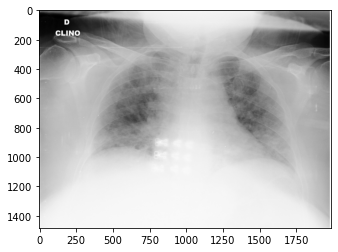

In [0]:
#check an image to see if it works
img_name = 'outputs01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg'
sample_check = load_img(covid_data_path / img_name)

print('Covid patient')
plt.imshow(sample_check)
plt.show()

In [0]:
#get the counts of each type of training data
#https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
list = os.listdir(normal_data_path)
num_normal = len(list)
print ('Number of normal data in training set:',num_normal)
list2 = os.listdir(covid_data_path)
num_sick = len(list2)
print ('Number of covid data intraining set:',num_sick)

Number of normal data in training set: 1341
Number of covid data intraining set: 3925


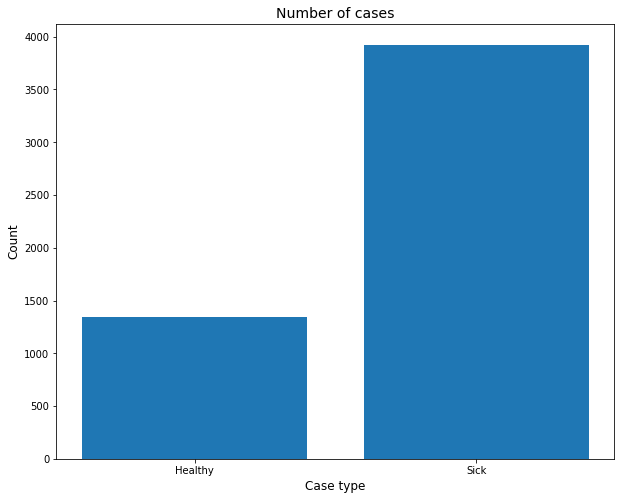

In [0]:
group_names=['Healthy', 'Sick']
cases_count=[num_normal, num_sick]
plt.figure(figsize=(10,8))
pyplot.bar(group_names, cases_count)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
#plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [0]:
#resize everything to 150,150 (?)
#check later to see if we can go with other sizes
all_data=[]
all_labels=[]
for img in tqdm(os.listdir(normal_data_path)):
    path = os.path.join(normal_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(0))



100%|██████████| 1341/1341 [12:34<00:00,  1.78it/s]


In [0]:
#resize eveything
for img in tqdm(os.listdir(covid_data_path)):
    path = os.path.join(covid_data_path,img)
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    img = cv2.resize(img, (150,150))
    #if img.shape[2] ==1:
    #   img = np.dstack([img, img, img])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img.astype(np.float32)/255.
    #label = to_categorical(0, num_classes=2)
    all_data.append(np.array(img))
    all_labels.append(str(1))

100%|██████████| 3925/3925 [29:59<00:00,  2.18it/s]


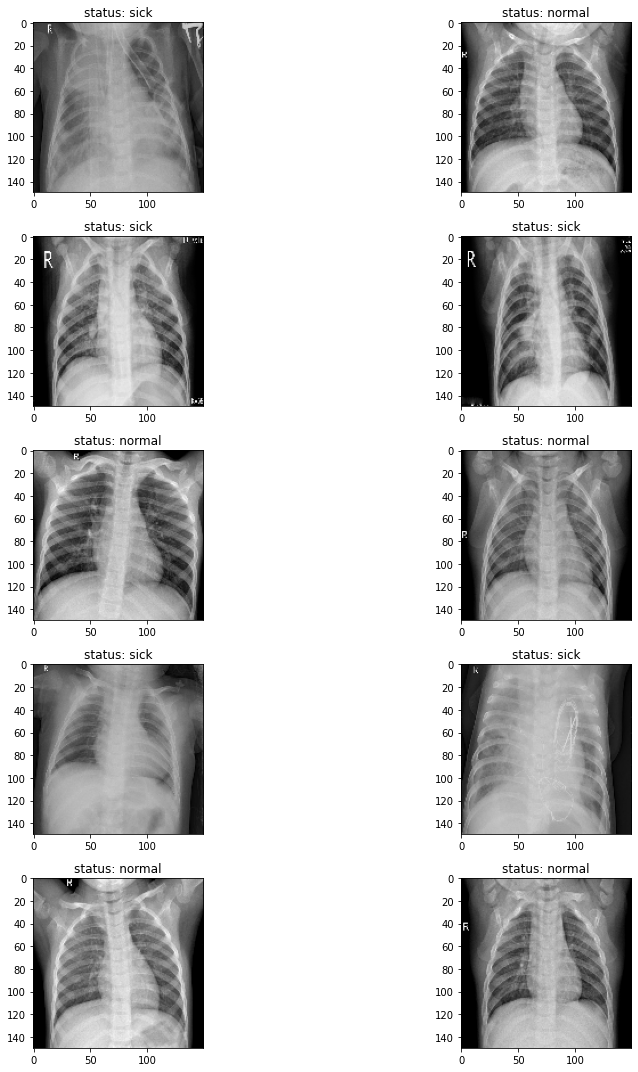

In [0]:
#print some random data
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(all_labels))
        ax[i,j].imshow(all_data[l])
        if all_labels[l]=='0':stat='normal'
        else:stat='sick'
        ax[i,j].set_title('status: '+ stat)      
plt.tight_layout()

In [0]:
all_labels = np.array(all_labels)
all_data = np.array(all_data)

In [0]:
#get training and test sets (use .25 as test size)
x_train,x_test,y_train,y_test=train_test_split(all_data,all_labels,test_size=0.25,random_state=42)

In [0]:
len(x_test), len(x_train)

(1317, 3949)

In [0]:
from keras.applications.resnet import ResNet50

In [0]:
base_model=ResNet50(include_top=False, weights='imagenet',input_shape=(150,150,3), pooling='avg')

94773248/94765736 [==============================] - 3s 0us/step


In [0]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [0]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='softmax'))

In [0]:
def build_model():
    input_img = Input(shape=(150,150,3), name='ImageInput')
    #x = Conv2D(32, (3,3), activation='relu' , padding='same', name='Conv1_1')(input_img)
    #x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    #x = MaxPooling2D((2,2), name='pool1')(x)
    
    #x = Conv2D(64, (3,3), activation='relu', padding='same',  name='Conv2_1')(x)
    #x = SeparableConv2D(128, (3,3), activation='relu',  padding='same', name='Conv2_2')(x)
    #x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = Conv2D(128, (3,3), activation='relu', padding='same', name='Conv3_1')(input_img)
    #x = BatchNormalization(name='bn1')(x)
    x = MaxPooling2D((2,2), name='pool3_1')(x)

    x = Conv2D(512, (3,3), activation='relu',  padding='same',name='Conv3_2')(x)
    #x = BatchNormalization(name='bn2')(x)
    x = MaxPooling2D((2,2), name='pool3_2')(x)

    #x = Conv2D(1024, (3,3), activation='relu',  padding='same', name='Conv3_3')(x)
    #x = MaxPooling2D((2,2), name='pool3_3')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(256, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(64, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(1, activation='sigmoid', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model=build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 150, 150, 3)       0         
_________________________________________________________________
Conv3_1 (Conv2D)             (None, 150, 150, 128)     3584      
_________________________________________________________________
pool3_1 (MaxPooling2D)       (None, 75, 75, 128)       0         
_________________________________________________________________
Conv3_2 (Conv2D)             (None, 75, 75, 512)       590336    
_________________________________________________________________
pool3_2 (MaxPooling2D)       (None, 37, 37, 512)       0         
_________________________________________________________________
flatten (Flatten)            (None, 700928)            0         
_________________________________________________________________
fc1 (Dense)                  (None, 256)               1794

In [0]:
#data augmentation?
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [0]:
epochs = 15
batch_size = 100

In [0]:
l_r = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=l_r)

In [0]:
# Fit the model
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/15
39/39 [==============================] - 1538s 39s/step - loss: 3.7921 - accuracy: 0.7529 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 2/15
39/39 [==============================] - 1523s 39s/step - loss: 3.7883 - accuracy: 0.7540 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 3/15
39/39 [==============================] - 1539s 39s/step - loss: 3.8034 - accuracy: 0.7501 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 4/15
39/39 [==============================] - 1549s 40s/step - loss: 3.8393 - accuracy: 0.7501 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 5/15
39/39 [==============================] - 1548s 40s/step - loss: 3.7844 - accuracy: 0.7542 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 6/15
39/39 [==============================] - 1549s 40s/step - loss: 3.8294 - accuracy: 0.7503 - val_loss: 4.1915 - val_accuracy: 0.7251
Epoch 7/15
39/39 [==============================] - 1493s 38s/step - loss: 3.7740 - accuracy: 0.7528 - val_loss: 4.1915 - val_accuracy: 0.7251

In [0]:
#(64,128,256) epoch=20, batch_size=16, accuracy=.7505, val_accuracy=.7251
#epoch=15,  batch_size=16, accuracy=.7505, val_accuracy=.7251
#(128,256,512)epoch=15,  batch_size=16, accuracy=.7508, val_accuracy=.7251
#(128,256)epoch=15,  batch_size=20, accuracy=.7539, val_accuracy=..7251


In [0]:
print(History.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


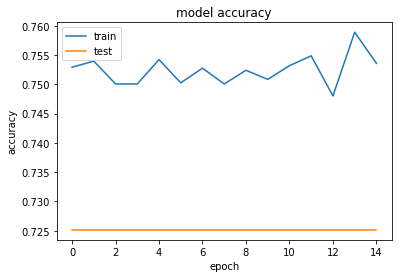

In [0]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

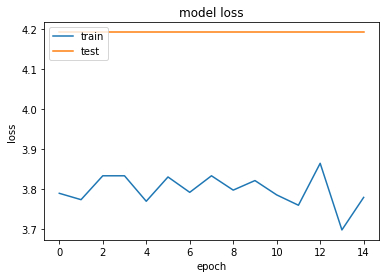

In [0]:
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Get predictions
train_preds = model.predict(all_data, batch_size=16)
train_preds = np.argmax(train_preds, axis=-1)

# Original labels
orig_train_labels = np.argmax(all_labels, axis=-1)

In [0]:
cm  = confusion_matrix(orig_train_labels, train_preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, alpha=0.7,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()


NameError: ignored